#Pytorch Computer Vision

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from  torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision import transforms

import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from tempfile import TemporaryDirectory


## Resources

- https://www.youtube.com/watch?v=V_xro1bcAuA&t=20116s
- https://pytorch.org/docs/stable/optim.html
- https://machinelearning.apple.com/
- https://github.com/AIVResearch/MSANet/blob/main/train.py
- https://pytorch.org/vision/0.19/models.html
- https://www.learnpytorch.io/03_pytorch_computer_vision/


# Step/Process

- Load in Data

The Noor Eye Hospital (NEH) dataset can be obtained at https://data.mendeley.com/datasets/8kt969dhx6/1, and the University of California San Diego (UCSD) dataset is available at https://data.mendeley.com/datasets/rscbjbr9sj.


- Create data pipeline for the model
- Choose model (Common Models, VGG-16, RESNET-50, ViT)
- Choose loss/optimizer (Loss Cross Entropy, Optimizer ADAM)
- Fit the model
- Predict


- #Reading the NEH dataset may be better, since it is smaller and faster.
- #For our classification we do not need an exceptionally large dataset.

## Reading Training and Testing Datasets
- Choose one of the following datasets to load into our program.

### Reading UCSD Dataset

In [1]:
! kaggle datasets download -d mmazizi/ucsd-3-class-labeled-retinal-oct-images
!unzip ucsd-3-class-labeled-retinal-oct-images.zip
#this is the San Diego UCSD Dataset.


Streaming output truncated to the last 5000 lines.
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-3.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-4.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-5.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-6.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-7.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-8.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9193451-9.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-1.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-10.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-2.jpeg  
  inflating: OCTUCSD-3class/OCTUCSD-3class/OCT/train/NORMAL/NORMAL-9194489-3.jpeg  
  inflating: OCTUCSD-3cl

In [ ]:
# Define the path to the dataset folder
dataset_path = '/content/OCTUCSD-3class/OCTUCSD-3class/OCT/train'

# Initialize an empty list to store image information
image_data = []

# Loop through each folder in the dataset directory
for label_folder in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_folder)

    # Check if the current item is a directory (to avoid files in the dataset root)
    if os.path.isdir(label_path):
        # Loop through all images in the current label folder
        for image_file in os.listdir(label_path):
            # Get the full path of the image
            image_path = os.path.join(label_path, image_file)
            # Append the image path and label to the image_data list
            image_data.append([image_path, label_folder])

# Create a DataFrame from the list
df = pd.DataFrame(image_data, columns=['image_path', 'label'])

# Show the first few rows of the DataFrame to verify
print(df.head())

In [ ]:
# Group by the 'label' column and count the number of images for each label
label_counts = df['label'].value_counts().reset_index()

# Rename the columns for better clarity
label_counts.columns = ['Label', 'Number of Images']

# Display the table
print(label_counts)

### Reading the NEH dataset

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/8kt969dhx6/files/d71da0c2-e314-4014-bec3-dcf6365b5ee1/file_downloaded
!wget https://data.mendeley.com/public-files/datasets/8kt969dhx6/files/53c33cfb-eb1b-4825-9bd1-d8b10998899d/file_downloaded
!unzip file_downloaded.zip

--2024-11-06 01:06:54--  https://data.mendeley.com/public-files/datasets/8kt969dhx6/files/d71da0c2-e314-4014-bec3-dcf6365b5ee1/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/36a1598f-7e03-4204-a426-3453ec0fb4c7 [following]
--2024-11-06 01:06:55--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/36a1598f-7e03-4204-a426-3453ec0fb4c7
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.92.35.194, 3.5.69.166, 3.5.72.21, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.92.35.194|:443... c

In [ ]:
!unzip file_downloaded

Streaming output truncated to the last 5000 lines.
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OD/027_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OD/028_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OD/029_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OD/030_Normal.tif  
   creating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/000_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/001_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/002_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/003_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/004_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/005_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/006_Normal.tif  
  inflating: NEH_UT_2021RetinalOCTDataset/NORMAL/115/OS/007_Normal.tif  
  inflating: NEH

### Testing Data

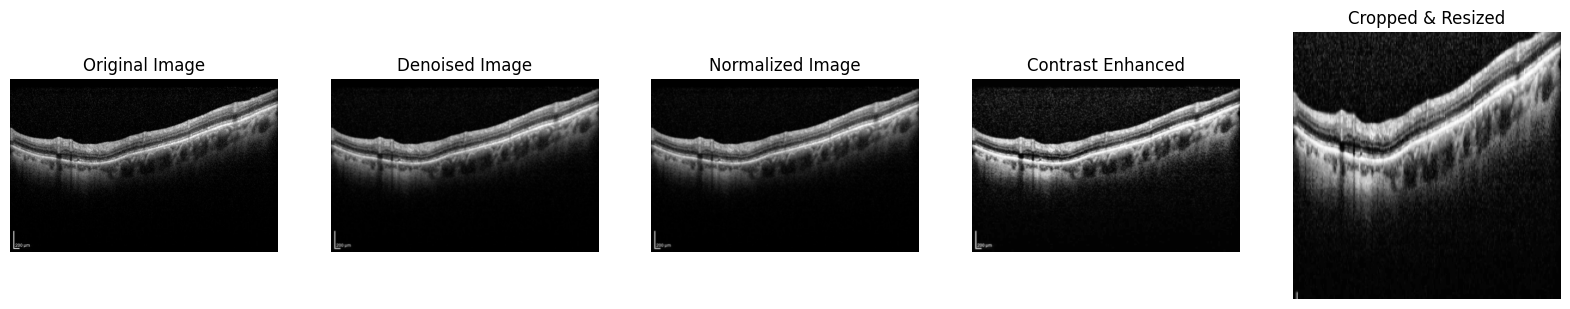

In [ ]:

# Load the image again for a fresh start
oct_image = cv.imread('/content/NEH_UT_2021RetinalOCTDataset/CNV/1/000_Drusen.jpg', 0)

# Step 1: Denoising using Gaussian Blur
denoised_image_cv = cv.GaussianBlur(oct_image, (5, 5), 0)

# Step 2: Normalization to scale pixel values to 0-255 range
normalized_image_cv = cv.normalize(denoised_image_cv, None, 0, 255, cv.NORM_MINMAX)

# Step 3: Contrast enhancement using CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe_cv = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
contrast_enhanced_image_cv = clahe_cv.apply(normalized_image_cv)

# Step 4: Cropping to focus on the main region (same parameters as before)
height, width = contrast_enhanced_image_cv.shape
cropped_image_cv = contrast_enhanced_image_cv[50:height-50, :]

# Step 5: Resizing to a standard input size (224x224) for models
resized_image_cv = cv.resize(cropped_image_cv, (224, 224), interpolation=cv.INTER_LINEAR)

# Display the original and processed images using OpenCV-style visualization
plt.figure(figsize=(20, 20))
plt.subplot(1, 5, 1)
plt.imshow(oct_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(denoised_image_cv, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.subplot(1, 5, 3)
plt.imshow(normalized_image_cv, cmap='gray')
plt.title('Normalized Image')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(contrast_enhanced_image_cv, cmap='gray')
plt.title('Contrast Enhanced')
plt.axis('off')

plt.subplot(1, 5, 5)
plt.imshow(resized_image_cv, cmap='gray')
plt.title('Cropped & Resized')
plt.axis('off')

plt.show()


## Reading Worst Case DATA


In [ ]:

#attempted to read in smaller dataset ie. worst case images from given code on mendeley.
csv_path   = '/content/file_downloaded.1'
file_path  = '/content/NEH_UT_2021RetinalOCTDataset/'

imageSize  = 224
def read_worstcase_images(file_path, csv_path):
    df = pd.read_csv(csv_path)

    image_label_pairs = []  # List to hold image-label pairs

    for patient_class in np.unique(df['Class']):
        df_classwise = df[df['Class'] == patient_class]

        for patient_index in np.unique(df_classwise['Patient ID']):
            df_patientwise = df_classwise[df_classwise['Patient ID'] == patient_index]

            for i in range(len(df_patientwise)):
                if df_patientwise.iloc[i]['Class'] == df_patientwise.iloc[i]['Label']:
                    img_path = file_path + df_patientwise.iloc[i]['Directory']
                    img = cv.imread(img_path)

                    if img is not None:  # Check if the image was loaded correctly
                        img = cv.resize(img, (imageSize, imageSize))
                        img = np.asarray(img)

                        label = df_patientwise.iloc[i]['Label'].lower()

                        # Map the label to an integer
                        if label == 'normal':
                            label_int = 0
                        elif label == 'drusen':
                            label_int = 1
                        elif label == 'cnv':
                            label_int = 2
                        else:
                            continue  # Skip any unexpected labels

                        image_label_pairs.append((img, label_int))  # Append tuple

                    print(patient_class, patient_index)

    return image_label_pairs

# Now you can iterate through the list of tuples
image_label_pairs = read_worstcase_images(file_path, csv_path)


Streaming output truncated to the last 5000 lines.
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16

In [ ]:
image_label_pairs = read_worstcase_images(file_path, csv_path)
#returns a list of lists, contains list[# number of image, img size, img size, color channels]

Streaming output truncated to the last 5000 lines.
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 15
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16
NORMAL 16

CNV


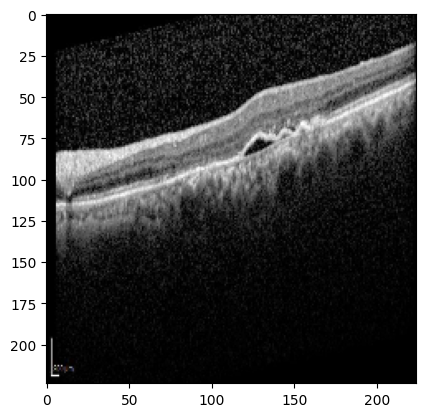

In [ ]:

# plt.imshow(x_patient[0][2])
# print(y_patient[0][2])
# print(label_id[y_patient[0][2]])
# print(len(x_patient), len(y_patient)) #shows that there are 441 lists of images, and the corresponding label id's
# img_array = np.array(x_patient[0])
# img_array.shape

label_id = ['Normal', 'Drusen', 'CNV']

plt.imshow(image_label_pairs[0][0])

image, label = image_label_pairs[0][0], image_label_pairs[0][1]
print(label_id[label])


## Model Setup and Fine-Tuning
Choices For Models
- Swin Transformer (2021)
- ConvNeXt (2022)
- MedT (2021)
- ViT (2022)

**Implementation**: Most of these models are implemented through timm/Hugging Face, since some of the models currently in pytorch are not as modern for the specific task.

https://huggingface.co/models?library=timm,pytorch&sort=trending

### Sources and Information
- https://github.com/huggingface/pytorch-image-models?tab=readme-ov-file#models

- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data

- https://www.nature.com/articles/s41598-024-70175-2

- https://www.mdpi.com/2075-4418/14/18/2009

- https://www.kaggle.com/code/macmyller/retinal-oct-project

## Visualize Data

image pre-processing: fine tune the model on images adjusted using open cv or on the default images of the dataset?

batch size: We select a batch size of data for training since training on the whole dataset at once. Benefits are faster training, and memory efficiency


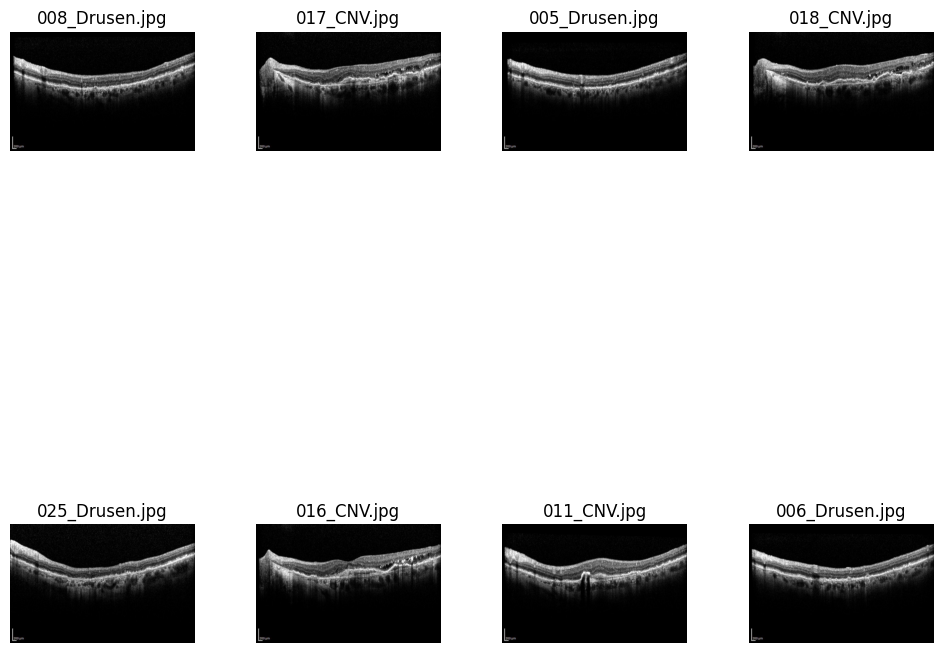

In [ ]:

#Returns a normalized pytorch tensor, mean and std values are commonly used.
def load_basic_img(image):
    #original shape ~ (496, 512, 3)
    image = cv.resize(image, (224, 224)) #resize, 224x224 is common practice.
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) #convert OpenCV default BGR to RGB
    #convert to pytorch tensor and normalize
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
                                ])
    img_trs = transform(image)
    return img_trs




#***we dont need this since we already read in the worst case data above****
def create_image_set():
    img_list = [] #create image list
    img_names = [] #create image name list
    path = glob.glob("/content/NEH_UT_2021RetinalOCTDataset/CNV/*/*.jpg") #path iterable to each testing file
    for i in path:
        image = cv.imread(i) #read in files
        img_list.append(image) #append to image list
        img_names.append(os.path.basename(i)) #append to image name list, takes base filename of the image IE 000_Drusen
    return img_list, img_names




img_list, img_names = create_image_set() #create a list of images
fig, axes = plt.subplots(2,4, figsize = (10,10)) #create visual layout for images, 2x2 grid
fig.tight_layout()          #layout images neatly

ind = 0
for ax,img in zip(axes.flat, img_list):
    ax.axis('off')
    ax.imshow(img) #show each image
    ax.set_title(img_names[ind]) #set title
    ind+=1

plt.show()


In [ ]:
#check and make sure we have our
print(len(img_list))
print(img_names)
print(len(img_names))

578
['008_Drusen.jpg', '017_CNV.jpg', '005_Drusen.jpg', '018_CNV.jpg', '025_Drusen.jpg', '016_CNV.jpg', '011_CNV.jpg', '006_Drusen.jpg', '010_Drusen.jpg', '022_CNV.jpg', '020_CNV.jpg', '000_Drusen.jpg', '024_Drusen.jpg', '023_Drusen.jpg', '013_CNV.jpg', '028_Drusen.jpg', '001_Drusen.jpg', '009_Drusen.jpg', '015_CNV.jpg', '003_Drusen.jpg', '029_Drusen.jpg', '014_CNV.jpg', '026_Drusen.jpg', '019_CNV.jpg', '012_CNV.jpg', '030_Drusen.jpg', '021_CNV.jpg', '027_Drusen.jpg', '004_Drusen.jpg', '002_Drusen.jpg', '007_Drusen.jpg', '017_CNV.jpg', '006_CNV.jpg', '018_CNV.jpg', '008_CNV.jpg', '025_Drusen.jpg', '016_CNV.jpg', '011_CNV.jpg', '023_CNV.jpg', '003_CNV.jpg', '000_CNV.jpg', '022_CNV.jpg', '020_CNV.jpg', '010_CNV.jpg', '013_CNV.jpg', '028_Drusen.jpg', '024_CNV.jpg', '015_CNV.jpg', '002_CNV.jpg', '004_CNV.jpg', '009_CNV.jpg', '029_Drusen.jpg', '014_CNV.jpg', '026_Drusen.jpg', '001_CNV.jpg', '005_CNV.jpg', '019_CNV.jpg', '012_CNV.jpg', '030_Drusen.jpg', '021_CNV.jpg', '027_Drusen.jpg', '007_

# Training the Model



## DataLoader

In [ ]:

class OCTDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image, label = self.image_label_pairs[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define data transformations for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Convert the image-label pairs into a dataset
full_dataset = OCTDataset(image_label_pairs=image_label_pairs, transform=None)

# Split the dataset into training and validation sets (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transformations to the training and validation sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoaders for training and validation
batch_size = 4  # Adjust based on your system's capacity
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Dictionary to access DataLoaders and dataset sizes
dataloaders = {
    'train': train_loader,
    'val': val_loader
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

#Device Agnostic Code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training Function

In [ ]:
import time
import copy
import torch
import os
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0


                 # Step the scheduler if in training phase
                if phase == 'train':
                    scheduler.step()

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward pass + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Update running statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                # Calculate and print epoch statistics
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Save the best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model




## Visualize Predictions Function

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Model Parameters
- classes
- img shape
- img dimensions
- feature extraction epochs
- fine-tuning epochs
- batch size
- optimizer

In [ ]:

IMG_SHAPE = (224, 224, 3) #tuple
FE_EPOCHS = 10
FT_EPOCHS = 10
BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()
model = torchvision.models.efficientnet_v2_s(weights="IMAGENET1K_V1")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #low learning rate for these images.
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers (e.g., first few layers or the entire classifier)
# EfficientNetV2-S has several blocks; here we assume you want to train the last layers.

# Unfreeze the final layers for fine-tuning
for param in model.features[-1].parameters():  # Adjust based on which layers you want to unfreeze
    param.requires_grad = True

# Alternatively, you might want to unfreeze the classifier layer:
for param in model.classifier.parameters():
    param.requires_grad = True

# Re-initialize the optimizer to update only the unfrozen layers
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 134MB/s]


In [ ]:
# Assuming you have a defined model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, and device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model_trained = train_model(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    num_epochs=25
)


Epoch 0/24
----------
train Loss: 0.7957 Acc: 0.6787


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


val Loss: 146996.2152 Acc: 0.7249

Epoch 1/24
----------
train Loss: 0.6558 Acc: 0.7302
val Loss: 0.5571 Acc: 0.7893

Epoch 2/24
----------
train Loss: 0.6140 Acc: 0.7437
val Loss: 4704.3926 Acc: 0.7980

Epoch 3/24
----------
train Loss: 0.5862 Acc: 0.7581
val Loss: 288137.2126 Acc: 0.7518

Epoch 4/24
----------
train Loss: 0.5561 Acc: 0.7709
val Loss: 0.4732 Acc: 0.8075

Epoch 5/24
----------
train Loss: 0.5521 Acc: 0.7730
val Loss: 171081.7551 Acc: 0.7443

Epoch 6/24
----------
train Loss: 0.5256 Acc: 0.7813
val Loss: 7106.3609 Acc: 0.7893

Epoch 7/24
----------
train Loss: 0.5260 Acc: 0.7852
val Loss: 1169950.9648 Acc: 0.7431

Epoch 8/24
----------
train Loss: 0.5057 Acc: 0.7914
val Loss: 0.4853 Acc: 0.8095

Epoch 9/24
----------
train Loss: 0.5037 Acc: 0.7966
val Loss: 3449.5520 Acc: 0.7945

Epoch 10/24
----------
train Loss: 0.4897 Acc: 0.7968
val Loss: 15109.8385 Acc: 0.7937

Epoch 11/24
----------
train Loss: 0.4859 Acc: 0.8047
val Loss: 89967.8664 Acc: 0.8059

Epoch 12/24
-----

<ipython-input-10-e8f9a5858d96>:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


##TO-DO:

- Fix Mistakes, Learn What went wrong

- Verify the data, (make sure the data is matched with the correct label)

- Retrain the model

- Visualize Predictions

- Try the other dataset

- Try other models

- use different optimizers/Learning Rates

- Re-evaluate the Training loop

- Check the fine-tuning process.

- feature extraction with https://huggingface.co/timm/tf_efficientnetv2_b0.in1k
model



#### Potential Mistakes

- Wrong image size for chosen model, look into EfficientNetV2 b0
- Incorrect Training function format/flow. View pytorch Errors
- Bad Calculations (unlikely)
- Mislabeled data, possibly due to how we read the data.
- Ensure balanced dataset to prevent bias.

